In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from itertools import combinations
from collections import Counter

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv("nyc311_10m_clean.csv")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [ ]:
demographics = {
    "borough": ["BROOKLYN", "QUEENS", "MANHATTAN", "THE BRONX", "STATEN ISLAND"],
    "median_income": [56942, 64509, 85071, 37397, 79201],   # USD
    "bachelor_or_higher_pct": [46.0, 38.8, 68.0, 22.8, 37.3]  # percent
}

demo_df = pd.DataFrame(demographics)

complaints_by_borough = (
    df["borough"].value_counts()
    .rename_axis("borough")
    .reset_index(name="total_complaints")
    .dropna()
)

merged_demo = complaints_by_borough.merge(demo_df, on="borough", how="left")
corr = merged_demo[["total_complaints", "median_income", "bachelor_or_higher_pct"]].corr()
corr


,total_complaints,median_income,bachelor_or_higher_pct
total_complaints,1.000000,-0.673161,0.259464
median_income,-0.673161,1.000000,0.512309
bachelor_or_higher_pct,0.259464,0.512309,1.000000


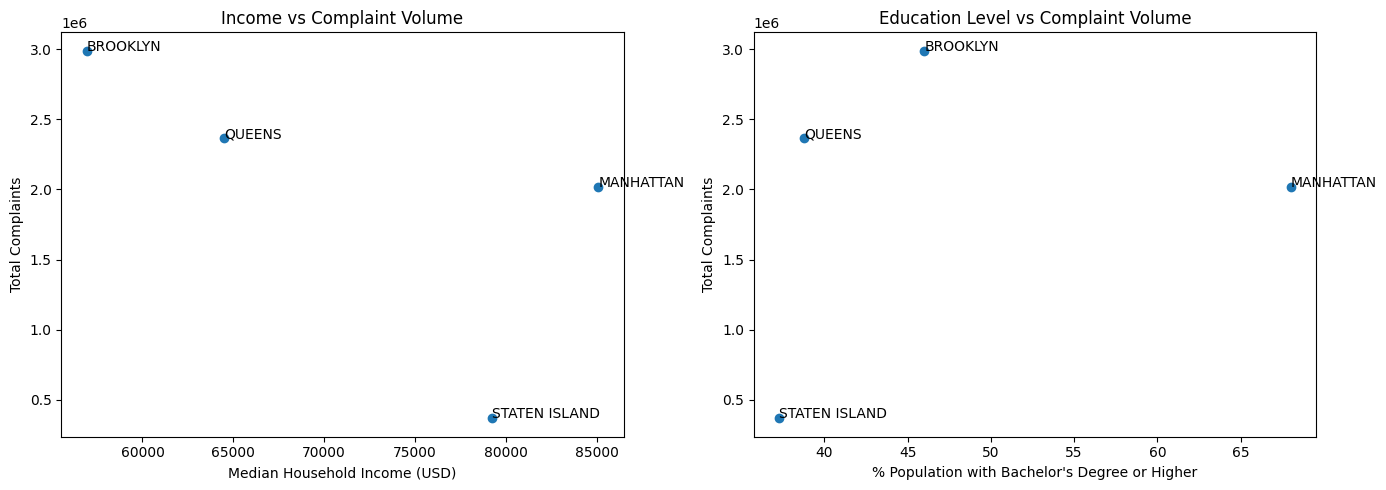

In [ ]:
# Scatter plots for demographics vs complaint volume
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(merged_demo["median_income"], merged_demo["total_complaints"])

for i, row in merged_demo.iterrows():
    axes[0].annotate(row["borough"], 
                     (row["median_income"], row["total_complaints"]))

axes[0].set_xlabel("Median Household Income (USD)")
axes[0].set_ylabel("Total Complaints")
axes[0].set_title("Income vs Complaint Volume")

axes[1].scatter(merged_demo["bachelor_or_higher_pct"], merged_demo["total_complaints"])

for i, row in merged_demo.iterrows():
    axes[1].annotate(row["borough"], 
                     (row["bachelor_or_higher_pct"], row["total_complaints"]))

axes[1].set_xlabel("% Population with Bachelor's Degree or Higher")
axes[1].set_ylabel("Total Complaints")
axes[1].set_title("Education Level vs Complaint Volume")

plt.tight_layout()
plt.show()


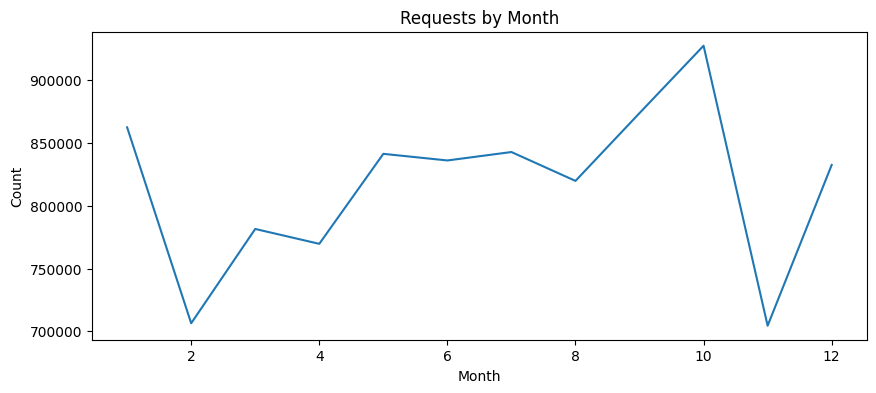

In [18]:
# Monthly trends
plt.figure(figsize=(10,4))
df['month'].value_counts().sort_index().plot(kind='line')
plt.title("Requests by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

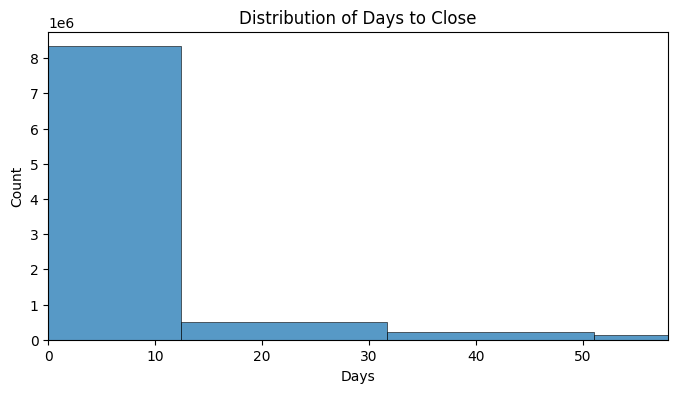

In [ ]:
# Distribution of closure duration
if "days_to_close" in df.columns:
    plt.figure(figsize=(8,4))

    valid_days = df["days_to_close"].dropna()

    sns.histplot(valid_days, bins=100, kde=False)
    plt.title("Distribution of Days to Close")
    plt.xlabel("Days")
    plt.ylabel("Count")
    plt.xlim(0, valid_days.quantile(0.95))  # remove long tail
    plt.show()


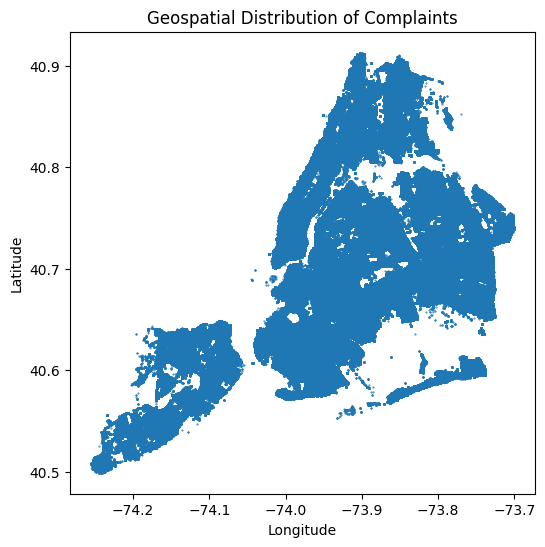

In [21]:
if "latitude" in df.columns and "longitude" in df.columns:
    plt.figure(figsize=(6,6))
    plt.scatter(df['longitude'], df['latitude'], s=0.2)
    plt.title("Geospatial Distribution of Complaints")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Total Rodent complaints: 112903


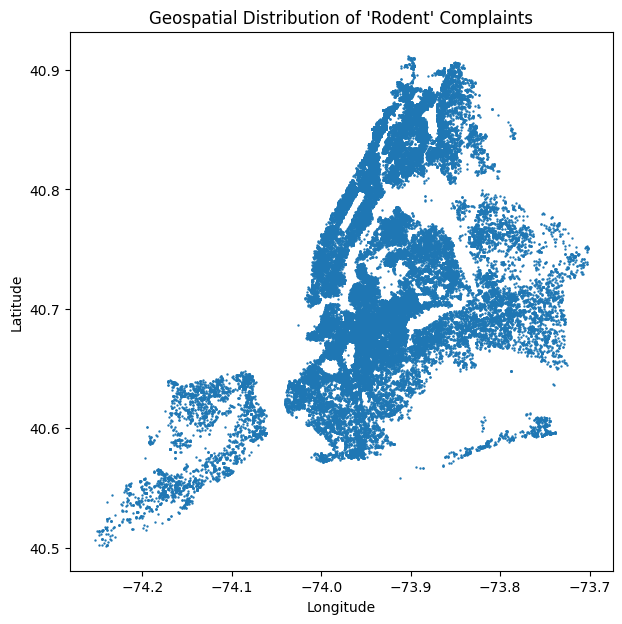

In [ ]:
# Geospatial plot for 'Rodent' complaints
dirty_df = df[df["complaint_type"] == "Rodent"].copy()

print("Total Rodent complaints:", len(dirty_df))

dirty_df = dirty_df.dropna(subset=["latitude", "longitude"])

plt.figure(figsize=(7,7))
plt.scatter(
    dirty_df["longitude"],
    dirty_df["latitude"],
    s=0.5
)
plt.title("Geospatial Distribution of 'Rodent' Complaints")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

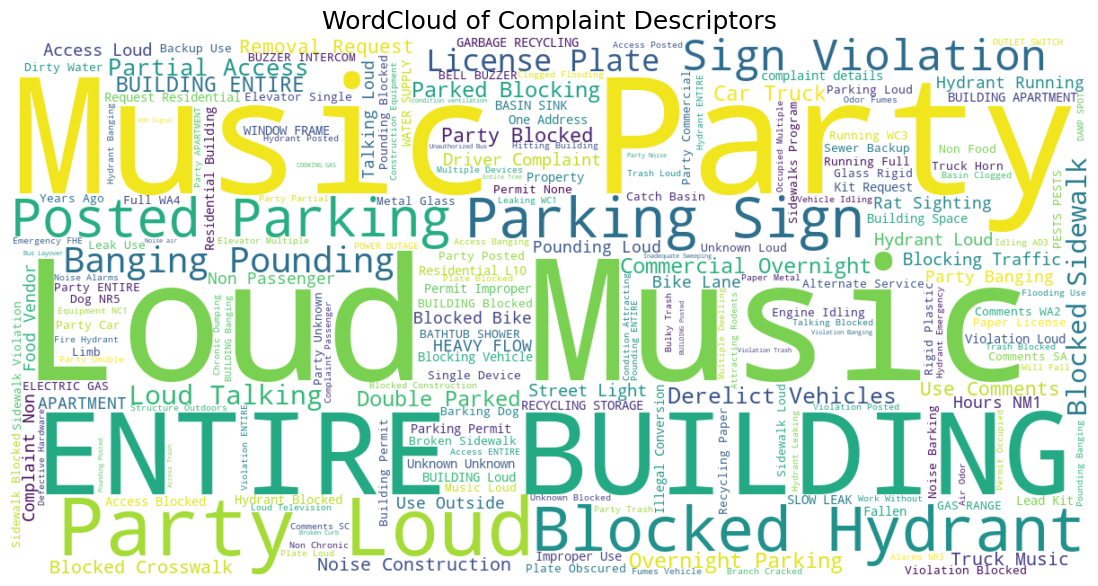

In [ ]:
# WordCloud for complaint descriptors
text_data = df['descriptor'].dropna().astype(str)

text = " ".join(text_data)

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    collocations=True
).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Complaint Descriptors", fontsize=18)
plt.show()


In [ ]:
# Top 10 zip codes by complaint volume
zip_counts = (
    df['incident_zip']
    .value_counts()
    .head(10)
    .reset_index()
)

zip_counts.columns = ['incident_zip', 'complaint_count']

print(zip_counts)


  incident_zip  complaint_count
0        10466           231372
1        11226           149857
2        10467           145682
3        10468           136242
4        10452           134169
5        11385           130444
6        10457           129601
7        11201           127763
8        10456           126731
9        10458           125853


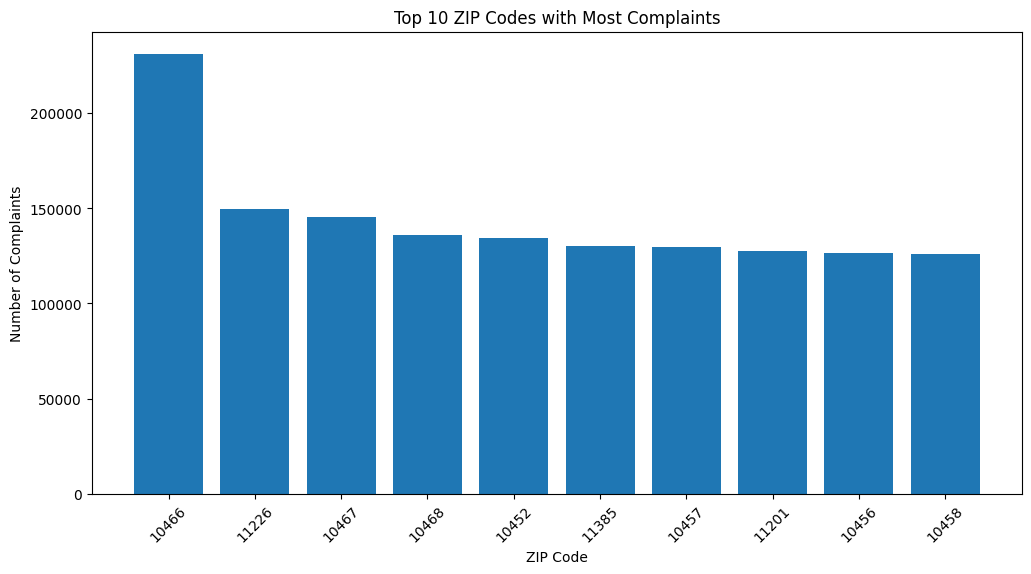

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(zip_counts['incident_zip'], zip_counts['complaint_count'])
plt.title("Top 10 ZIP Codes with Most Complaints")
plt.xlabel("ZIP Code")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.show()

In [ ]:
cat_cols = [
    "agency",
    "complaint_type",
    "descriptor",
    "borough",
    "location_type",
    "city",
    "incident_address",
    "street_name",
    "incident_zip",
    "status"
]

cat_cols

['agency',
 'complaint_type',
 'descriptor',
 'borough',
 'location_type',
 'city',
 'incident_address',
 'street_name',
 'incident_zip',
 'status']

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.head()

,unique_key,created_date,closed_date,year,month,dayofweek,hour,agency,complaint_type,descriptor,borough,location_type,city,incident_address,street_name,incident_zip,latitude,longitude,days_to_close,status,location
0,66778147,2025-11-10 01:50:51,NaN,2025,11,0,1,12,96,183,0,140,6,516900,10628,118,40.843562,-73.818153,NaN,2,"(40.84356202395745, -73.81815325101906)"
1,66780206,2025-11-10 01:49:45,NaN,2025,11,0,1,12,128,336,2,140,47,444323,2673,23,40.798611,-73.968892,NaN,2,"(40.7986109485515, -73.96889161417334)"
2,66777208,2025-11-10 01:47:32,NaN,2025,11,0,1,12,127,557,2,140,47,216719,9140,38,40.861171,-73.925885,NaN,2,"(40.86117080770446, -73.92588494147341)"
3,66779171,2025-11-10 01:47:12,NaN,2025,11,0,1,12,96,742,1,140,7,144935,3970,150,40.614502,-73.975140,NaN,2,"(40.61450200215088, -73.97514014922876)"
4,66779189,2025-11-10 01:47:09,NaN,2025,11,0,1,12,126,55,1,107,7,55787,5944,167,40.690267,-73.921293,NaN,2,"(40.690266694713586, -73.92129345228891)"


In [20]:
cluster_features = [
    "latitude",
    "longitude",
    "hour",
    "dayofweek",
    "month",
    "complaint_type"
]

df_cluster = df[cluster_features].dropna()

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster)

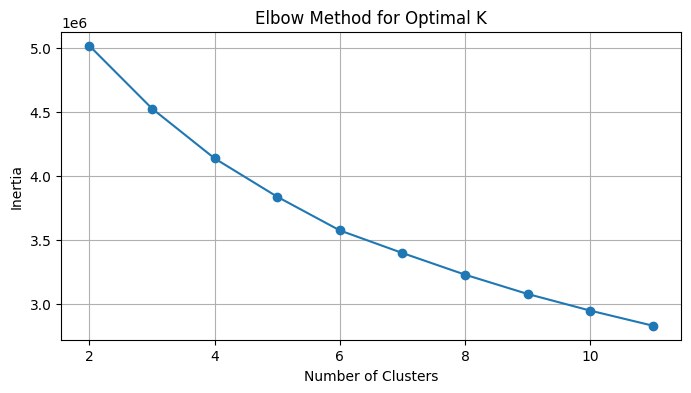

In [ ]:
# Determine optimal K using Elbow Method
inertia = []

K_range = range(2, 12)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [23]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, n_init=20, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X)

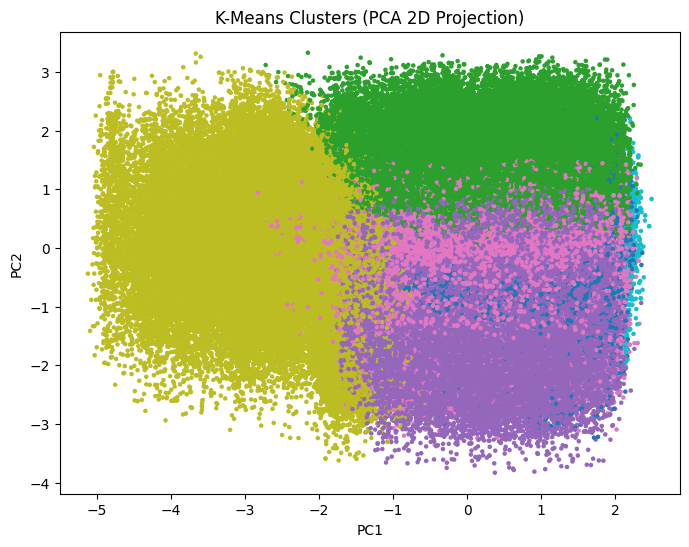

In [ ]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_cluster["cluster"], s=5, cmap="tab10")
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [25]:
cluster_summary = df_cluster.join(df[["borough", "agency"]]).groupby("cluster").agg({
    "complaint_type": "median",
    "hour": "median",
    "dayofweek": "median",
    "month": "median",
    "latitude": "mean",
    "longitude": "mean"
})

cluster_summary

,complaint_type,hour,dayofweek,month,latitude,longitude
cluster,,,,,,
0,101.0,13.0,1.0,9.0,40.785196,-73.897426
1,101.0,18.0,5.0,8.0,40.749858,-73.910263
2,27.0,13.0,2.0,9.0,40.738748,-73.866836
3,97.0,3.0,5.0,9.0,40.751090,-73.912592
4,74.0,13.0,2.0,9.0,40.637491,-74.012005
5,96.0,17.0,4.0,10.0,40.761483,-73.910317


In [26]:
df_cluster.groupby("cluster")["complaint_type"].value_counts().head(20)

cluster  complaint_type
0        101               29972
         74                27762
         151               13959
         102               10994
         66                 9271
         164                7252
         111                5674
         110                5646
         137                4782
         161                4226
         96                 4166
         159                4162
         149                3872
         138                3805
         131                3091
         103                2975
         124                2912
         130                2300
         97                 2235
         109                2230
Name: count, dtype: int64

In [ ]:
# DBSCAN Clustering
coords = df[["latitude", "longitude"]].dropna().to_numpy()

db = DBSCAN(eps=0.01, min_samples=50, n_jobs=-1).fit(coords)

df["dbscan_cluster"] = -1
df.loc[df[["latitude", "longitude"]].dropna().index, "dbscan_cluster"] = db.labels_

: 

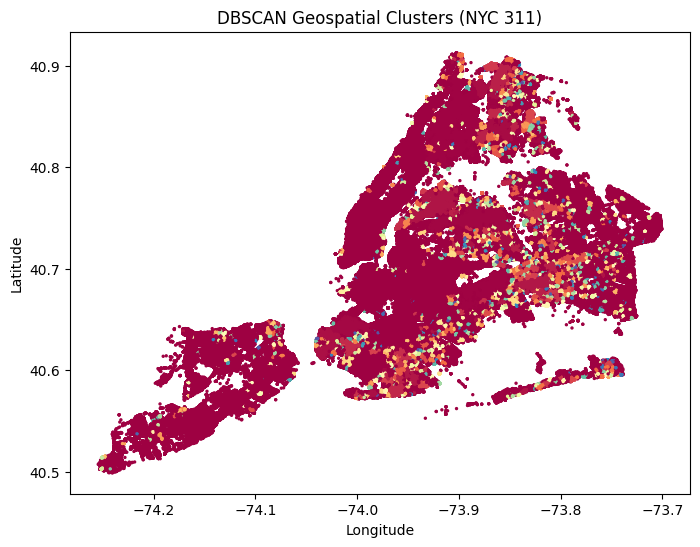

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(df["longitude"], df["latitude"], c=df["dbscan_cluster"], s=2, cmap="Spectral")
plt.title("DBSCAN Geospatial Clusters (NYC 311)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# Complaint Type Co-occurrence Analysis (Geospatial Only)
df_geo = df[['latitude', 'longitude', 'complaint_type']].dropna().copy()

df_geo['lat_bin'] = df_geo['latitude'].round(3)
df_geo['lon_bin'] = df_geo['longitude'].round(3)

grouped = df_geo.groupby(["lat_bin", "lon_bin"])["complaint_type"].apply(list)

pair_counts = Counter()

for complaints in grouped:
    unique_complaints = set(complaints)
    for c1, c2 in combinations(sorted(unique_complaints), 2):
        pair_counts[(c1, c2)] += 1

cooccurrence_geo = (
    pd.DataFrame([
        {"complaint_1": k[0], "complaint_2": k[1], "count": v}
        for k, v in pair_counts.items()
    ])
    .sort_values("count", ascending=False)
)

cooccurrence_geo.head(20)


,complaint_1,complaint_2,count
338,96,126,36516
90,18,96,35908
323,96,216,34388
9,4,96,33551
547,96,179,31040
707,52,96,30278
435,18,126,29865
184,96,115,29748
470,96,127,29572
138,51,96,29114


In [ ]:
complaint_encoder = label_encoders["complaint_type"]

cooccurrence_geo["complaint_1_label"] = complaint_encoder.inverse_transform(
    cooccurrence_geo["complaint_1"]
)

cooccurrence_geo["complaint_2_label"] = complaint_encoder.inverse_transform(
    cooccurrence_geo["complaint_2"]
)

cooccurrence_geo.head(20)

,complaint_1,complaint_2,count,complaint_1_label,complaint_2_label
338,96,126,36516,Illegal Parking,Noise - Residential
90,18,96,35908,Blocked Driveway,Illegal Parking
323,96,216,34388,Illegal Parking,Water System
9,4,96,33551,Abandoned Vehicle,Illegal Parking
547,96,179,31040,Illegal Parking,Street Condition
707,52,96,30278,Dirty Condition,Illegal Parking
435,18,126,29865,Blocked Driveway,Noise - Residential
184,96,115,29748,Illegal Parking,Missed Collection
470,96,127,29572,Illegal Parking,Noise - Street/Sidewalk
138,51,96,29114,Derelict Vehicles,Illegal Parking


/var/folders/3l/skzqjx4536sg_944vc9xb1j80000gn/T/ipykernel_27150/138529485.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




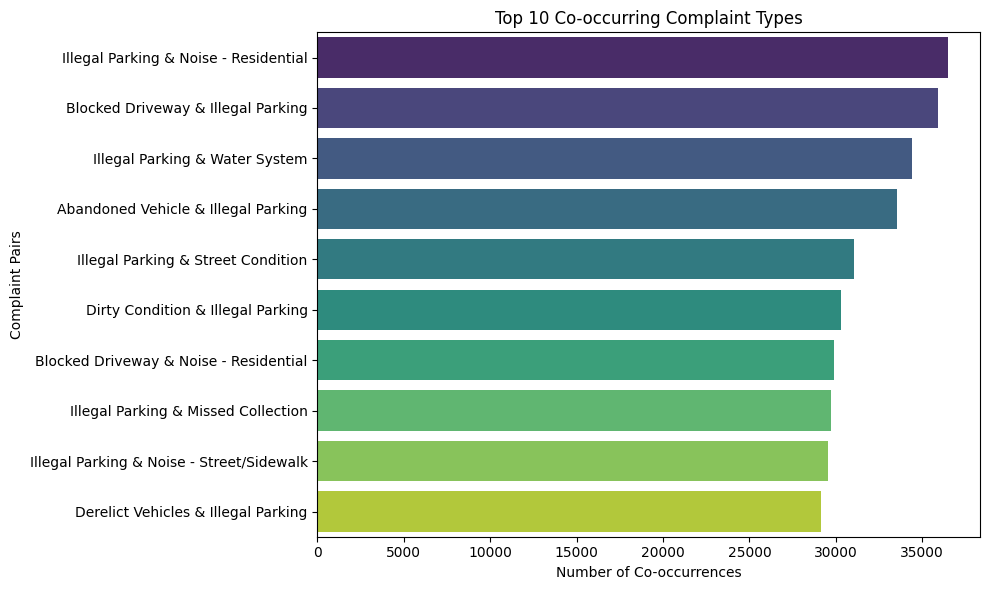

In [ ]:
top_pairs = cooccurrence_geo.head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x="count",
    y=top_pairs.apply(lambda row: f"{row['complaint_1_label']} & {row['complaint_2_label']}", axis=1),
    data=top_pairs,
    palette="viridis"
)
plt.xlabel("Number of Co-occurrences")
plt.ylabel("Complaint Pairs")
plt.title("Top 10 Co-occurring Complaint Types")
plt.tight_layout()
plt.show()


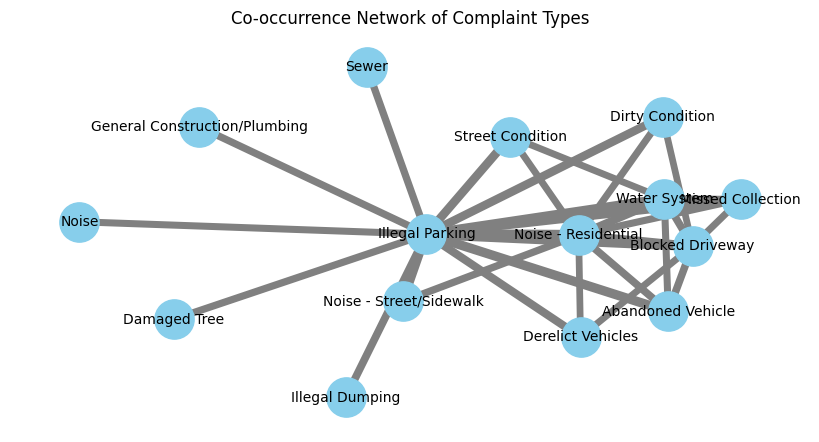

In [ ]:
top_n = 30
top_pairs = cooccurrence_geo.head(top_n)

G = nx.Graph()

for _, row in top_pairs.iterrows():
    G.add_edge(row['complaint_1_label'], row['complaint_2_label'], weight=row['count'])

plt.figure(figsize=(8, 4))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges()
weights = [G[u][v]['weight']/5000 for u,v in edges]

nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color='skyblue',
    width=weights,
    edge_color='gray',
    font_size=10
)
plt.title("Co-occurrence Network of Complaint Types")
plt.show()


In [ ]:
transactions = (
    df.groupby("incident_address")["complaint_type"]
      .apply(list)
      .tolist()
)

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
frequent_itemsets = apriori(
    df_te,
    min_support=0.002,
    use_colnames=True
)

frequent_itemsets.sort_values("support", ascending=False).head()

: 

In [ ]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.3
)

In [ ]:
rules_filtered = rules[
    (rules['support'] >= 0.002) &
    (rules['confidence'] >= 0.4) &
    (rules['lift'] >= 1.2)
].sort_values("lift", ascending=False)

In [14]:
def rule_to_text(row):
    return f"{set(row['antecedents'])} → {set(row['consequents'])} | support={row.support:.3f}, confidence={row.confidence:.3f}, lift={row.lift:.3f}"

for i, row in rules_filtered.head(20).iterrows():
    print(rule_to_text(row))

{151, 61, 55} → {33, 110, 111} | support=0.002, confidence=0.503, lift=85.149
{33, 61, 110} → {151, 55, 111} | support=0.002, confidence=0.483, lift=84.102
{151, 33, 110, 111} → {61, 55} | support=0.002, confidence=0.410, lift=83.702
{61, 55} → {151, 33, 110, 111} | support=0.002, confidence=0.427, lift=83.702
{61, 110, 111} → {151, 33, 55} | support=0.002, confidence=0.442, lift=83.160
{33, 55, 111} → {61, 110, 151} | support=0.002, confidence=0.478, lift=80.926
{61, 110, 55} → {151, 33, 111} | support=0.002, confidence=0.550, lift=80.504
{61, 55, 111} → {33, 110, 151} | support=0.002, confidence=0.594, lift=79.960
{33, 61, 110, 151} → {55, 111} | support=0.002, confidence=0.553, lift=79.939
{33, 61, 151} → {55, 110, 111} | support=0.002, confidence=0.411, lift=78.580
{151, 33, 55, 111} → {61, 110} | support=0.002, confidence=0.551, lift=78.358
{151, 61, 110, 111} → {33, 55} | support=0.002, confidence=0.500, lift=78.188
{61, 55} → {33, 110, 111} | support=0.002, confidence=0.461, lif

In [ ]:
complaint_encoder = label_encoders["complaint_type"]

def decode_itemset(itemset):
    """Decode a frozenset of numeric codes into readable labels."""
    decoded = complaint_encoder.inverse_transform(list(itemset))
    return set(decoded)

def rule_to_text_decoded(row):
    antecedents = decode_itemset(row['antecedents'])
    consequents = decode_itemset(row['consequents'])

    return (
        f"{antecedents} → {consequents} | "
        f"support={row.support:.3f}, "
        f"confidence={row.confidence:.3f}, "
        f"lift={row.lift:.3f}"
    )

for i, row in rules_filtered.head(20).iterrows():
    print(rule_to_text_decoded(row))

{'FLOORING/STAIRS', 'UNSANITARY CONDITION', 'GENERAL'} → {'PAINT/PLASTER', 'PLUMBING', 'DOOR/WINDOW'} | support=0.002, confidence=0.503, lift=85.149
{'PAINT/PLASTER', 'GENERAL', 'DOOR/WINDOW'} → {'UNSANITARY CONDITION', 'PLUMBING', 'FLOORING/STAIRS'} | support=0.002, confidence=0.483, lift=84.102
{'UNSANITARY CONDITION', 'PAINT/PLASTER', 'PLUMBING', 'DOOR/WINDOW'} → {'FLOORING/STAIRS', 'GENERAL'} | support=0.002, confidence=0.410, lift=83.702
{'FLOORING/STAIRS', 'GENERAL'} → {'UNSANITARY CONDITION', 'PAINT/PLASTER', 'PLUMBING', 'DOOR/WINDOW'} | support=0.002, confidence=0.427, lift=83.702
{'PAINT/PLASTER', 'PLUMBING', 'GENERAL'} → {'FLOORING/STAIRS', 'UNSANITARY CONDITION', 'DOOR/WINDOW'} | support=0.002, confidence=0.442, lift=83.160
{'FLOORING/STAIRS', 'PLUMBING', 'DOOR/WINDOW'} → {'UNSANITARY CONDITION', 'PAINT/PLASTER', 'GENERAL'} | support=0.002, confidence=0.478, lift=80.926
{'FLOORING/STAIRS', 'PAINT/PLASTER', 'GENERAL'} → {'UNSANITARY CONDITION', 'PLUMBING', 'DOOR/WINDOW'} | su

In [ ]:
# Contrast using percentage difference
freq_total = df_cp['complaint_type_decoded'].value_counts(normalize=True)

contrasts = []

for borough, group in df_cp.groupby('borough_decoded'):
    freq_boro = group['complaint_type_decoded'].value_counts(normalize=True)

    for ctype in freq_boro.index:
        lift = freq_boro[ctype] / freq_total[ctype]
        contrasts.append({
            'borough': borough,
            'complaint_type': ctype,
            'borough_freq': freq_boro[ctype],
            'city_freq': freq_total[ctype],
            'lift': lift
        })

contrast_df = pd.DataFrame(contrasts)

top_lift = (
    contrast_df.sort_values('lift', ascending=False)
               .groupby('borough')
               .head(10)
)

print(top_lift)


            borough                                 complaint_type  \
1054    Unspecified                            Bike Rack Condition   
1057    Unspecified                                      Bike Rack   
827   STATEN ISLAND                  Electronics Waste Appointment   
992   STATEN ISLAND                                           SRDE   
981   STATEN ISLAND                                        Tanning   
1006    Unspecified                       Traffic Signal Condition   
930   STATEN ISLAND           Special Natural Area District (SNAD)   
997   STATEN ISLAND                                  Internal Code   
1028    Unspecified                            Hazardous Materials   
1004  STATEN ISLAND                          Executive Inspections   
844   STATEN ISLAND                                Illegal Posting   
927   STATEN ISLAND                                     Poison Ivy   
1039    Unspecified                       Noise - House of Worship   
1008    Unspecified 

In [ ]:
# Contrast using percentage difference
city_pct = df_cp['complaint_type_decoded'].value_counts(normalize=True)

boro_pct = df_cp.groupby('borough_decoded')['complaint_type_decoded'].value_counts(normalize=True)

contrast_list = []

for (borough, ctype), pct in boro_pct.items():
    diff = pct - city_pct.get(ctype, 0)
    contrast_list.append({
        'borough': borough,
        'complaint_type': ctype,
        'borough_pct': pct,
        'city_pct': city_pct.get(ctype, 0),
        'difference': diff
    })

contrast_simple = pd.DataFrame(contrast_list)

top_diff = contrast_simple.sort_values('difference', ascending=False).groupby('borough').head(10)

print(top_diff)


            borough                 complaint_type  borough_pct  city_pct  \
1006    Unspecified       Traffic Signal Condition     0.215116  0.012204   
1008    Unspecified               Street Condition     0.104651  0.015132   
0             BRONX            Noise - Residential     0.183748  0.109650   
1             BRONX                 HEAT/HOT WATER     0.133617  0.077864   
1009    Unspecified         Street Light Condition     0.063953  0.009547   
202        BROOKLYN                Illegal Parking     0.196090  0.154629   
617          QUEENS                Illegal Parking     0.194506  0.154629   
618          QUEENS               Blocked Driveway     0.089051  0.050845   
820   STATEN ISLAND              Missed Collection     0.046847  0.013608   
1011    Unspecified                Illegal Dumping     0.040698  0.011251   
1013    Unspecified             Vendor Enforcement     0.034884  0.006720   
1014    Unspecified             Consumer Complaint     0.032946  0.005931   

In [ ]:
# Top spikes in daily anomalies
top_spikes = (
    daily_anomalies.sort_values("z_score", ascending=False)
                   .groupby("complaint_type")
                   .head(3)
)

top_spikes

,created_date,complaint_type,count,rolling_mean,rolling_std,z_score,anomaly
53699,2024-02-04,95,3,1.285714,0.755929,2.267787,True
67613,2024-05-29,170,2,1.142857,0.377964,2.267787,True
93821,2024-12-27,113,2,1.142857,0.377964,2.267787,True
11192,2023-02-25,172,2,1.142857,0.377964,2.267787,True
85066,2024-10-15,118,2,1.142857,0.377964,2.267787,True
...,...,...,...,...,...,...,...
52308,2024-01-23,166,35,10.714286,15.923926,1.525108,True
7453,2023-01-25,152,2,1.285714,0.487950,1.463850,True
12175,2023-03-05,221,2,1.285714,0.487950,1.463850,True
13245,2023-03-14,221,2,1.285714,0.487950,1.463850,True


In [ ]:
# IQR-based anomaly detection
def detect_iqr_anomalies(df_group):
    Q1 = df_group["count"].quantile(0.25)
    Q3 = df_group["count"].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    df_group["anomaly_iqr"] = df_group["count"] > threshold
    return df_group

daily_iqr = daily.groupby("complaint_type").apply(detect_iqr_anomalies)
daily_iqr[daily_iqr["anomaly_iqr"] == True].head(20)

/var/folders/3l/skzqjx4536sg_944vc9xb1j80000gn/T/ipykernel_27150/1346947758.py:9: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



created_date  complaint_type  count  rolling_mean  \
complaint_type                                                           
0              905     2022-12-01               0      2           NaN   
               1022    2022-12-02               0      2           NaN   
               1970    2022-12-10               0      2           NaN   
               2320    2022-12-13               0      2           NaN   
               2803    2022-12-17               0      2           NaN   
               6912    2023-01-21               0      2      1.285714   
               7490    2023-01-26               0      2      1.285714   
               7740    2023-01-28               0      2      1.428571   
               8694    2023-02-05               0      4      1.857143   
               14825   2023-03-28               0      2      1.142857   
               16045   2023-04-07               0      2      1.285714   
               17033   2023-04-15               0      2      1.428571   
               17402   2023-04-18               0      2      1.428571   
               19014   2023-05-01               0      2      1.428571   
               19658   2023-05-06               0      2      1.285714   
               20794   2023-05-15               0      2      1.428571   
               21556   2023-05-21               0      2      1.428571   
               23436   2023-06-05               0      2      1.428571   
               29378   2023-07-22               0      3      1.285714   
               32069   2023-08-12               0      4      1.714286   

                      rolling_std   z_score  anomaly  anomaly_iqr  
complaint_type                                                     
0              905            NaN       NaN    False         True  
               1022           NaN       NaN    False         True  
               1970           NaN       NaN    False         True  
               2320           NaN       NaN    False         True  
               2803           NaN       NaN    False         True  
               6912      0.487950  1.463850     True         True  
               7490      0.487950  1.463850     True         True  
               7740      0.534522  1.069045    False         True  
               8694      1.069045  2.004459     True         True  
               14825     0.377964  2.267787     True         True  
               16045     0.487950  1.463850     True         True  
               17033     0.534522  1.069045    False         True  
               17402     0.534522  1.069045    False         True  
               19014     0.534522  1.069045    False         True  
               19658     0.487950  1.463850     True         True  
               20794     0.534522  1.069045    False         True  
               21556     0.534522  1.069045    False         True  
               23436     0.534522  1.069045    False         True  
               29378     0.755929  2.267787     True         True  
               32069     1.253566  1.823369     True         True